# Batching

This notebook shows how to use and test the NeighborCellsLoader, which is the topological counterpart of NeighborLoader from torch_geometric.

The module presents itself as

```
loader = NeighborCellsLoader(data,rank=rank,num_neighbors=[-1],input_nodes=input_mask,batch_size=batch_size,shuffle=False)
```
where

    - data: Dataset to apply batching to.
    
    - rank: The rank of cells that we want to work on. The labels should correspond to these cells.

    - num_neighbors: List with maximum number of neighbors to consider for each hop. For example [-1, 10] whould consider all neighbors for the first hop, and at maximum 10 neighbors for the second hop.

    - input_nodes: A mask to specify the "seed" cells, that is the cells that we want to run the model over.

    - batch_size: How many seed cells to consider for each iteration.

    - shuffle: Should be True for training.

## Important

The loader, for the target rank, will **not** return a number of cells equal to *batch_size*, since the neighboring cells will also be included. The loader returns a parameter named **n_seed_cells** which indicates how many seed cells were selected (usually n_seed_cells is equal to batch_size, but for the end of the dataset this is not always true). The first n_seed_cells cells are the seed cells. This means that to properly use this loader, the model's loss (as well as any metric) should be calculated only using the first n_seed_cells cells. 

## Imports and utilities

In [1]:
import os, shutil, rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

%load_ext autoreload
%autoreload 2

import hydra
import torch
import torch_geometric
from hydra import compose, initialize
from omegaconf import OmegaConf

from topobench.data.utils.utils import load_manual_graph
from topobench.data.preprocessor import PreProcessor
from topobench.dataloader.dataloader import TBDataloader
from topobench.data.loaders import PlanetoidDatasetLoader

from topobench.data.batching.neighbor_cells_loader import NeighborCellsLoader
from topobench.data.preprocessor import PreProcessor
from topomodelx.nn.simplicial.scn2 import SCN2
from topomodelx.nn.cell.cwn import CWN
from topomodelx.nn.hypergraph.allset_transformer import AllSetTransformer

from topobench.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)

initialize(config_path="../configs", job_name="job")

/home/marco/miniforge3/envs/topobench/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()
/tmp/ipykernel_441851/1779135539.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from matplotlib.patches import Polygon
from itertools import combinations
from typing import Optional, Dict, List

def plot_graph(
    data,
    face_color_map: Optional[Dict[int, str]] = None,
    node_size: int = 500,
    font_size: int = 12,
    seed: int = 5,
    show: bool = True
) -> plt.Figure:
    """
    Visualize a simplicial complex from a PyTorch Geometric Data object.
    
    Args:
        data: torch_geometric.data.Data object containing the simplicial complex
        face_color_map: Dictionary mapping number of tetrahedrons to colors
        node_size: Size of nodes in the visualization
        font_size: Size of font for labels
        seed: Random seed for layout
        show: Whether to display the plot immediately
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Default color map if none provided
    if face_color_map is None:
        face_color_map = {
            0: "pink",
            1: "gray",
            2: "blue",
            3: "blue",
            4: "orange",
            5: "purple",
            6: "red",
            7: "brown",
            8: "black",
            9: "gray",
        }
    
    # Extract vertices
    num_vertices = data.num_nodes if hasattr(data, 'num_nodes') else data.x.shape[0]
    vertices = list(range(num_vertices))
    
    # Extract edges from incidence matrix
    edges = []
    for edge in abs(data.incidence_1.to_dense().T):
        edges.append(torch.where(edge == 1)[0].numpy())
    edges = np.array(edges)
    
    # Extract tetrahedrons if available
    tetrahedrons = []
    if hasattr(data, 'tetrahedrons'):
        tetrahedrons = data.tetrahedrons
    elif hasattr(data, 'incidence_2'):
        # Extract tetrahedrons from incidence_2 matrix if available
        for tetra in abs(data.incidence_2.to_dense().T):
            tetrahedrons.append(torch.where(tetra == 1)[0].tolist())
    
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    
    # Find triangular cliques
    cliques = list(nx.enumerate_all_cliques(G))
    cliques = [triangle for triangle in cliques if len(triangle) == 3]
    
    # Create layout
    pos = nx.spring_layout(G, seed=seed)
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    
    # Draw nodes and labels
    node_labels = {i: f"v_{n.item()}" for i,n in enumerate(data.n_id)} if hasattr(data, 'n_id') else {i: f"v_{i}" for i in G.nodes()}
    nx.draw(
        G,
        pos,
        labels=node_labels,
        node_size=node_size,
        node_color="skyblue",
        font_size=font_size,
    )
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="g", width=2, alpha=0.5)
    
    # # Add edge labels
    for i, (u, v) in enumerate(edges):
        x = (pos[u][0] + pos[v][0]) / 2
        y = (pos[u][1] + pos[v][1]) / 2
        plt.text(x, y, f"e_{i}", fontsize=font_size - 2, color="r")
    
    # Color the faces (cliques)
    for clique in cliques:
        # Count tetrahedrons containing this clique
        counter = 0
        for tetrahedron in tetrahedrons:
            for comb in combinations(tetrahedron, 3):
                if set(clique) == set(comb):
                    counter += 1
        
        # Create and add polygon
        polygon = [pos[v] for v in clique]
        poly = Polygon(
            polygon,
            closed=True,
            facecolor=face_color_map.get(counter, "gray"),  # Default to gray if counter not in map
            edgecolor="pink",
            alpha=0.3,
        )
        plt.gca().add_patch(poly)
    
    plt.title(f"Graph with cliques colored ({num_vertices} vertices)")
    
    if show:
        plt.show()
    

## Different use cases

### Manual Simplicial Graph

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], coadjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], coadjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], coadjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], coadjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])


Processing...
Done!


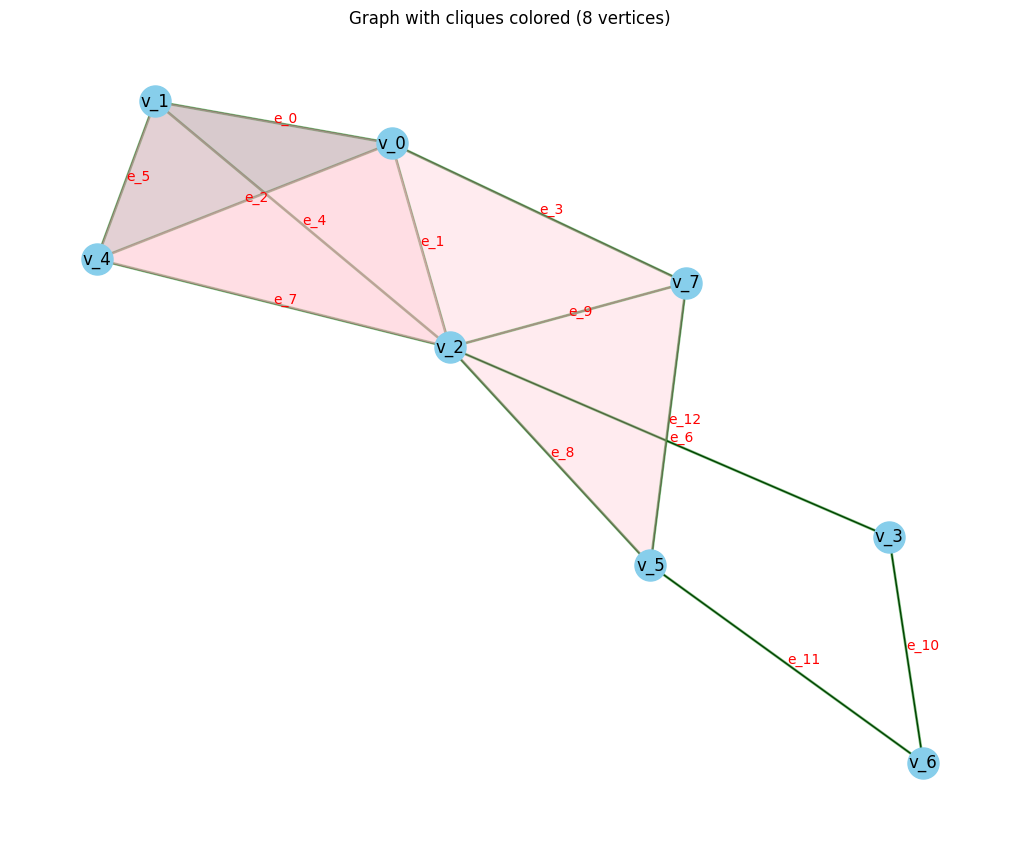

In [3]:
path = "./graph2simplicial_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/manual_dataset", "model=simplicial/san"], 
              return_hydra_config=True)

data = load_manual_graph()
preprocessed_dataset = PreProcessor(data, './', cfg['transforms'])
data = preprocessed_dataset[0]
print(data)
plot_graph(data)

In [4]:
# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 0
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

y = torch.zeros(n_cells, dtype=torch.long)
data.y = y

data

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], coadjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], coadjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], coadjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], coadjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])

In [5]:
batch_size = 1
rank = 0
loader = NeighborCellsLoader(data,
                             rank=rank,
                             num_neighbors=[-1],
                             input_nodes=train_mask,
                             batch_size=batch_size,
                             shuffle=False)

In [6]:
for batch in loader:
    print(batch)

Data(x=[5, 1], edge_index=[2, 16], y=[5], num_nodes=5, incidence_0=[1, 5], down_laplacian_0=[5, 5], up_laplacian_0=[5, 5], adjacency_0=[5, 5], coadjacency_0=[8, 8], hodge_laplacian_0=[5, 5], incidence_1=[5, 8], down_laplacian_1=[8, 8], up_laplacian_1=[8, 8], adjacency_1=[8, 8], coadjacency_1=[13, 13], hodge_laplacian_1=[8, 8], incidence_2=[8, 5], down_laplacian_2=[5, 5], up_laplacian_2=[5, 5], adjacency_2=[5, 5], coadjacency_2=[6, 6], hodge_laplacian_2=[5, 5], incidence_3=[5, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], coadjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[5, 1], x_1=[8, 1], x_2=[5, 1], x_3=[1, 1], cells_ids=[4], n_id=[5], batch_0=[5], batch=[5], batch_1=[8], batch_2=[5], batch_3=[1], n_seed_cells=1)
Data(x=[4, 1], edge_index=[2, 12], y=[4], num_nodes=4, incidence_0=[1, 4], down_laplacian_0=[4, 4], up_laplacian_0=[4, 4], adjacency_0=[4, 4], coadjacency_0=[8, 8], hodge_laplacian_0=[4, 4], incidence_1=[4, 6], down_laplacian_1=[6, 6], 

In [7]:
a = next(iter(loader))
print(a)

print(a['incidence_1'].to_dense())

Data(x=[5, 1], edge_index=[2, 16], y=[5], num_nodes=5, incidence_0=[1, 5], down_laplacian_0=[5, 5], up_laplacian_0=[5, 5], adjacency_0=[5, 5], coadjacency_0=[8, 8], hodge_laplacian_0=[5, 5], incidence_1=[5, 8], down_laplacian_1=[8, 8], up_laplacian_1=[8, 8], adjacency_1=[8, 8], coadjacency_1=[13, 13], hodge_laplacian_1=[8, 8], incidence_2=[8, 5], down_laplacian_2=[5, 5], up_laplacian_2=[5, 5], adjacency_2=[5, 5], coadjacency_2=[6, 6], hodge_laplacian_2=[5, 5], incidence_3=[5, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], coadjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[5, 1], x_1=[8, 1], x_2=[5, 1], x_3=[1, 1], cells_ids=[4], n_id=[5], batch_0=[5], batch=[5], batch_1=[8], batch_2=[5], batch_3=[1], n_seed_cells=1)
tensor([[1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 1., 1., 0.]])


Data(x=[5, 1], edge_index=[2, 16], y=[5], num_nodes=5, incidence_0=[1, 5], down_laplacian_0=[5, 5], up_laplacian_0=[5, 5], adjacency_0=[5, 5], coadjacency_0=[8, 8], hodge_laplacian_0=[5, 5], incidence_1=[5, 8], down_laplacian_1=[8, 8], up_laplacian_1=[8, 8], adjacency_1=[8, 8], coadjacency_1=[13, 13], hodge_laplacian_1=[8, 8], incidence_2=[8, 5], down_laplacian_2=[5, 5], up_laplacian_2=[5, 5], adjacency_2=[5, 5], coadjacency_2=[6, 6], hodge_laplacian_2=[5, 5], incidence_3=[5, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], coadjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[5, 1], x_1=[8, 1], x_2=[5, 1], x_3=[1, 1], cells_ids=[4], n_id=[5], batch_0=[5], batch=[5], batch_1=[8], batch_2=[5], batch_3=[1], n_seed_cells=1)
The cells of rank 0 that were originally selected are [0]
Selected cells of rank 0: tensor([0, 7, 1, 2, 4])
Incidence 3:
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.]])
Incidence 2:
tensor([[1., 1., 0., 0., 0.],
 

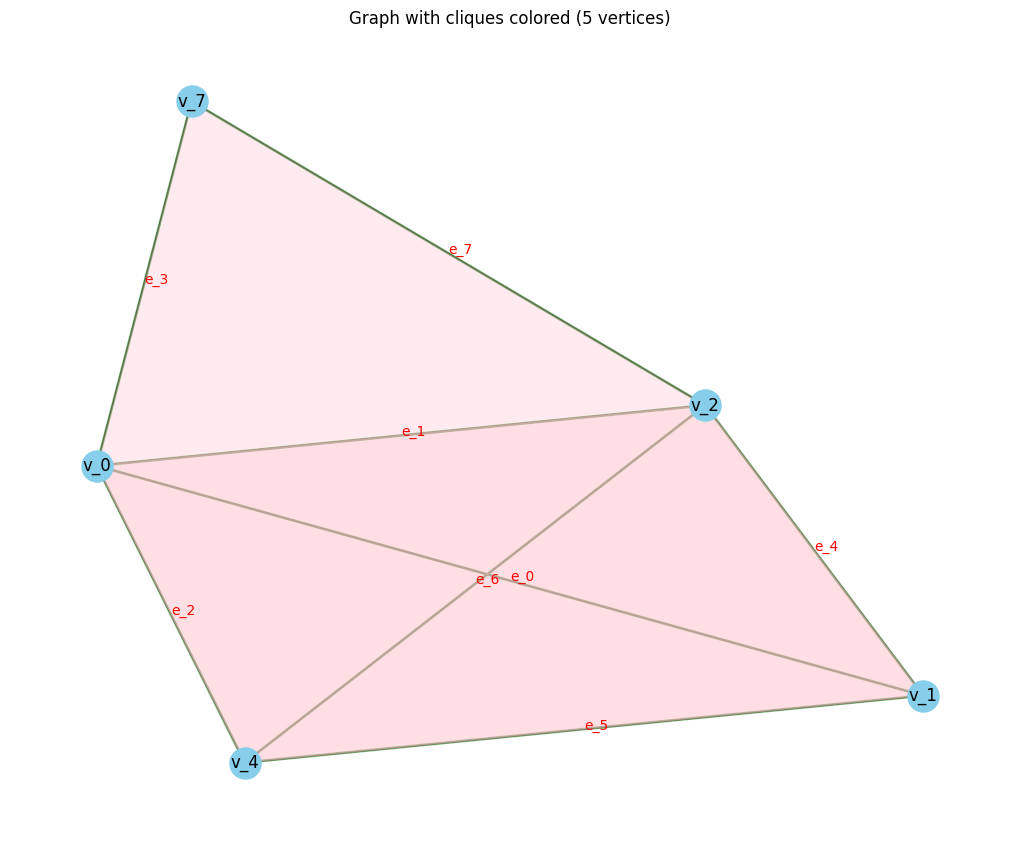

In [8]:
for batch in loader:
    print(batch)
    n_seed_cells = batch.n_seed_cells
    print(f"The cells of rank {rank} that were originally selected are {batch.n_id[:n_seed_cells].tolist()}")
    
    print(f"Selected cells of rank {rank}: {batch.n_id}")
    if hasattr(batch, 'incidence_hyperedges'):
        print("Incidence hyperedges:")
        print(batch.incidence_hyperedges.to_dense())
    else:
        print("Incidence 3:")
        print(batch.incidence_3.to_dense())
        print("Incidence 2:")
        print(batch.incidence_2.to_dense())
        print("Incidence 1:")
        print(batch.incidence_1.to_dense())
    if rank == 0:
        plot_graph(batch)
    break

## Testing NeighborCellLoader

If batching is done correctly the results on the selected cells should not change when compared to the results obtained over the whole graph.
We test this to check that our batching strategy is correct.

### Testing simplicial complexes

In [9]:
path = "./graph2simplicial_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_citeseer", "model=simplicial/scn"], 
              return_hydra_config=True)

dataset_loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = dataset_loader.load()
# Preprocess dataset and load the splits
transform_config = cfg.get("transforms", None)
preprocessor = PreProcessor(dataset, dataset_dir, transform_config)
dataset_train, dataset_val, dataset_test = (
    preprocessor.load_dataset_splits(cfg.dataset.split_params)
)

### Full batch --------------------------------------------------------
cfg.dataset.dataloader_params.batch_size = -1

datamodule = TBDataloader(
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        dataset_test=dataset_test,
        **cfg.dataset.get("dataloader_params", {}),
    )

input_dim = 3703
hidden_channels = 16
out_dim = 7

model = SCN2(input_dim, input_dim, input_dim, n_layers=1)
model.eval()

train_dataloader = datamodule.train_dataloader()
for data in train_dataloader:
    x_0_full, x_1_full, x_2_full = model(data.x_0, data.x_1, data.x_2, data.hodge_laplacian_0, data.hodge_laplacian_1, data.hodge_laplacian_2)

### Batched --------------------------------------------------------
print("Testing batching for SCN2 using 2 layers.")
print("We return the MSE between the full batch and the batched version.")
batch_size = 100
for n_hops in range(1,4):
    cfg.dataset.dataloader_params.batch_size = batch_size

    datamodule_batched = TBDataloader(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            dataset_test=dataset_test,
            num_neighbors = [-1] * n_hops,
            rank=0,
            **cfg.dataset.get("dataloader_params", {}),
        )
    train_dataloader_batched = datamodule_batched.train_dataloader()
    mse0 = []
    for i, batch in enumerate(train_dataloader_batched):
        x_0_batch, x_1_batch, x_2_batch = model(batch.x_0, batch.x_1, batch.x_2, batch.hodge_laplacian_0, batch.hodge_laplacian_1, batch.hodge_laplacian_2)
        n_seed_cells = batch.n_seed_cells
        n_ids = batch.n_id[:n_seed_cells]
        mse0.append(torch.mean((x_0_full[n_ids, :] - x_0_batch[:n_seed_cells, :]).pow(2)).item())
    print(f"    n_hops = {n_hops}   MSE: {sum(mse0) / len(mse0)}")

Transform parameters are the same, using existing data_dir: /home/marco/Documents/phd/TopoBench/datasets/graph/cocitation/citeseer/graph2simplicial_lifting/1041777450
Testing batching for SCN2 using 2 layers.
We return the MSE between the full batch and the batched version.
    n_hops = 1   MSE: 8.575653068789447e-22
    n_hops = 2   MSE: 3.728962896237994e-15
    n_hops = 3   MSE: 3.7710704548636816e-15


In [10]:
n_hops = 1
batch_size=100
cfg.dataset.dataloader_params.batch_size = batch_size
datamodule_batched = TBDataloader(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            dataset_test=dataset_test,
            num_neighbors = [-1] * n_hops,
            rank=0,
            drop_last=False,  # Ensure we get all batches even if not full
            **cfg.dataset.get("dataloader_params", {}),
        )
train_dataloader_batched = datamodule_batched.train_dataloader()
val_dataloader_batched = datamodule_batched.val_dataloader()
test_dataloader_batched = datamodule_batched.test_dataloader()

mask_idx = datamodule_batched.dataset_train[0][1].index(f"train_mask")
train_idxs = datamodule_batched.dataset_train[0][0][mask_idx]

In [11]:
mask_idx = datamodule_batched.dataset_train[0][1].index(f"val_mask")
val_idxs = datamodule_batched.dataset_train[0][0][mask_idx]
mask_idx = datamodule_batched.dataset_train[0][1].index(f"test_mask")
test_idxs = datamodule_batched.dataset_train[0][0][mask_idx]

print(f"Number of training cells: {len(train_idxs)}")
print(f"Number of validation cells: {len(val_idxs)}")
print(f"Number of test cells: {len(test_idxs)}")

print("Intersection train val:", len(set(train_idxs).intersection(set(val_idxs))))
print("Intersection train test:", len(set(train_idxs).intersection(set(test_idxs))))

Number of training cells: 1663
Number of validation cells: 831
Number of test cells: 833
Intersection train val: 0
Intersection train test: 0


In [12]:
print("Chek that all the nodes in the training set are selected.")
train_nodes_indices = []
for batch in train_dataloader_batched:
    num_seed_nodes = batch.n_seed_cells
    train_nodes_indices += batch.n_id[:num_seed_nodes].tolist()

train_nodes_indices = set(train_nodes_indices)
print(f"Number of nodes selected: {len(train_nodes_indices)}")
intersection = set(train_idxs.tolist()).intersection(train_nodes_indices)
print(f"Number of nodes in the training set: {len(train_idxs)}")
print(f"Intersection: {len(intersection)}")

print("Check that there is no intersection between different splits.")
val_nodes_indices = []
for batch in val_dataloader_batched:
    num_seed_nodes = batch.n_seed_cells
    val_nodes_indices += batch.n_id[:num_seed_nodes].tolist()
val_nodes_indices = set(val_nodes_indices)
intersection_val = train_nodes_indices.intersection(val_nodes_indices)
print(f"Number of nodes in the validation set: {len(val_nodes_indices)}")
print(f"Intersection with training set: {len(intersection_val)}")

test_nodes_indices = []
for batch in test_dataloader_batched:
    num_seed_nodes = batch.n_seed_cells
    test_nodes_indices += batch.n_id[:num_seed_nodes].tolist()
test_nodes_indices = set(test_nodes_indices)
intersection_test = train_nodes_indices.intersection(test_nodes_indices)
print(f"Number of nodes in the test set: {len(test_nodes_indices)}")
print(f"Intersection with training set: {len(intersection_test)}")


Chek that all the nodes in the training set are selected.
Number of nodes selected: 1663
Number of nodes in the training set: 1663
Intersection: 1663
Check that there is no intersection between different splits.
Number of nodes in the validation set: 831
Intersection with training set: 0
Number of nodes in the test set: 833
Intersection with training set: 0


### Testing hypergraphs

In [13]:
path = "./graph2hypergraph_lifting/"
if os.path.isdir(path):
    shutil.rmtree(path)
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_cora", "model=hypergraph/allsettransformer"], 
              return_hydra_config=True)

dataset_loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = dataset_loader.load()
# Preprocess dataset and load the splits
transform_config = cfg.get("transforms", None)
preprocessor = PreProcessor(dataset, dataset_dir, transform_config)
dataset_train, dataset_val, dataset_test = (
    preprocessor.load_dataset_splits(cfg.dataset.split_params)
)

### Full batch --------------------------------------------------------
cfg.dataset.dataloader_params.batch_size = -1

datamodule = TBDataloader(
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        dataset_test=dataset_test,
        **cfg.dataset.get("dataloader_params", {}),
    )

input_dim = 1433
hidden_channels = 16
out_dim = 7
n_layers = 3
model = AllSetTransformer(input_dim, hidden_channels, n_layers=n_layers)
model.eval()

train_dataloader = datamodule.train_dataloader()
for data in train_dataloader:
    x_0_full, x_1_full = model(data.x_0, data.incidence_hyperedges)

### Batched --------------------------------------------------------
print(f"Testing batching for AllSetTransformer using {n_layers} layers.")
print("We return the MSE between the full batch and the batched version.")
batch_size = 4
for n_hops in range(1, 10):
    cfg.dataset.dataloader_params.batch_size = batch_size

    datamodule_batched = TBDataloader(
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            dataset_test=dataset_test,
            num_neighbors = [-1] * n_hops,
            **cfg.dataset.get("dataloader_params", {}),
        )
    train_dataloader_batched = datamodule_batched.train_dataloader()
    mse = 0
    for i, batch in enumerate(train_dataloader_batched):
        x_0_batch, x_1_batch = model(batch.x_0, batch.incidence_hyperedges)
        n_seed_cells = batch.n_seed_cells
        n_ids = batch.n_id[:n_seed_cells]
        mse += torch.mean((x_0_full[n_ids, :] - x_0_batch[:n_seed_cells, :]).pow(2)).item()
    mse = mse / (i + 1)
        
    # The last element might be False since the last batch might not be full
    print(f"    n_hops = {n_hops}   MSE: {mse}")

Processing...
Done!


Testing batching for AllSetTransformer using 3 layers.
We return the MSE between the full batch and the batched version.
    n_hops = 1   MSE: 0.00020962883400122784
    n_hops = 2   MSE: 2.599935610516969e-05
    n_hops = 3   MSE: 1.6998626835044827e-06
    n_hops = 4   MSE: 3.394543597343368e-08
    n_hops = 5   MSE: 3.1338654944837566e-10
    n_hops = 6   MSE: 5.881224017182615e-15
    n_hops = 7   MSE: 5.520872623796304e-15
    n_hops = 8   MSE: 5.4466138749633295e-15
    n_hops = 9   MSE: 5.495188737729045e-15
